In [1]:
col_names = [
    'dv', 
    'fv',
    'dv-fv'
]

In [2]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['Media-cloud']

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
# Get counts of each collection 

count_fv = db['fv'].find({}).count()
count_dv = db['dv'].find({}).count()
count_fv_dv = db['dv-fv'].find({}).count()

# Top Words

In [6]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Stop words
stop = set(stopwords.words('english'))
stop.update([
    'say',
    'would',
    'year',
    'one',
    'go',
    'get',
    'take',
    'also',
    'need',
    'want',
    'make',
    'family',
    'domestic'
])

# Lemmatizer
lmtz = WordNetLemmatizer()

In [7]:
# Lemmatize words to their base form

def lemmatize(token):
    lemma = lmtz.lemmatize(token, 'v')
    if lemma == token:
        lemma = lmtz.lemmatize(token, 'n')
    return lemma

In [ ]:
freqs = {}                           # Word frequency
for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Count processed stories and display
    
    for story in col.find({}):
        if story['title'] != None:
            text = story['title']
            
            for token in word_tokenize(text):
                if token.isalpha():
                    lemma = lemmatize(token.lower())               # Lemmatize word and update its frequency
                    if lemma not in stop:
                        freqs[lemma] = freqs.get(lemma, 0) + 1
                        
        counter += 1
        if counter % 1000 == 0:
            print(counter,'precessed')

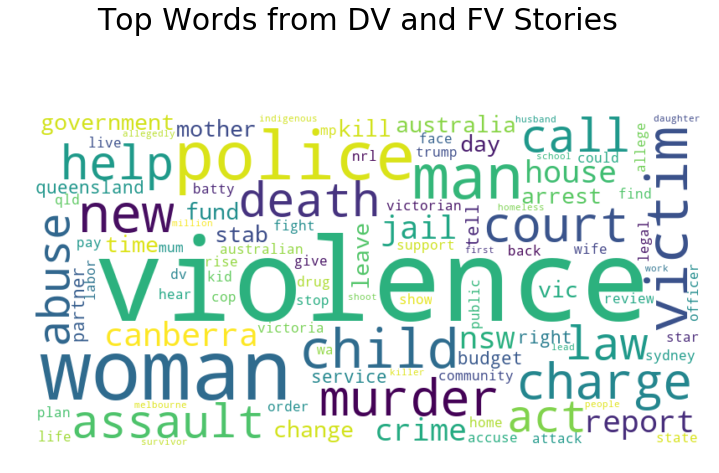

In [9]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white")
wordcloud.generate_from_frequencies(frequencies=freqs)

plt.figure(figsize=(12,8)).suptitle('Top Words from DV and FV Stories', fontsize=30)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

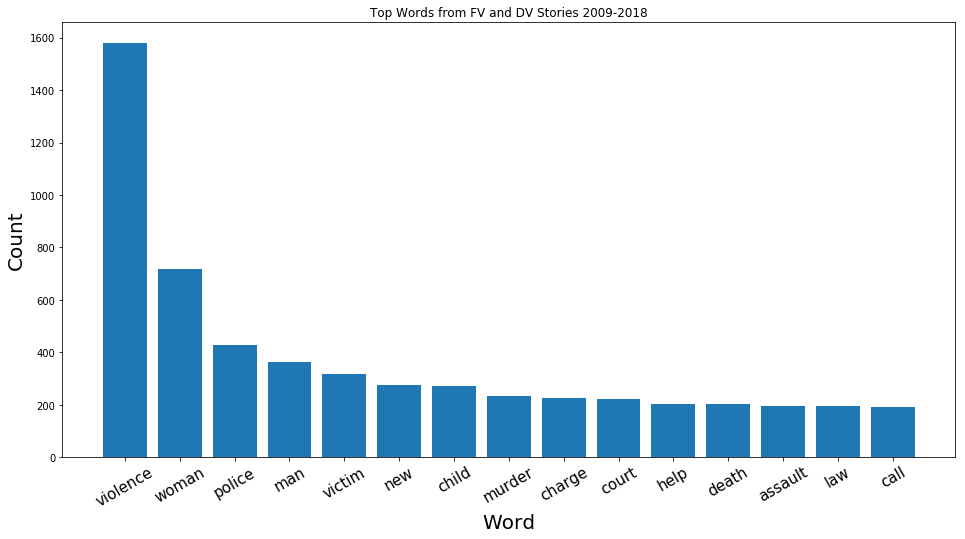

In [10]:
# Bar chart

import numpy as np

x = []          # X axis - top words
y = []          # Y axis - word counts
count = 0       # Numer of top words to show

for word in sorted(freqs, key=freqs.get, reverse=True):
    x.append(word)
    y.append(freqs[word])
    count += 1
    if count == 15:
        break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=15, rotation=30)
plt.title('Top Words from FV and DV Stories 2009-2018')
plt.show()

# N-Gram

In [ ]:
# Bi-gram

from nltk import sent_tokenize

bigram_counts = {}                   # Stores count of bigrams, eg bigram_counts[('i','like')] = 12345

for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Track process
    
    for story in col.find({}, no_cursor_timeout=True):

        tokens = []                                        # Store cleaned word tokens
        for token in word_tokenize(story['title']):
            if token.isalpha():
                lemma = lemmatize(token.lower())               # Lemmatize
                if lemma not in stop:
                    tokens.append(lemma)

        for i, token in enumerate(tokens):
            if i == len(tokens) - 1:
                break
            bigram_counts[(token, tokens[i+1])] = bigram_counts.get((token, tokens[i+1]), 0) + 1
                
        counter += 1
        if counter % 100 == 0:
            print(counter,'processed')

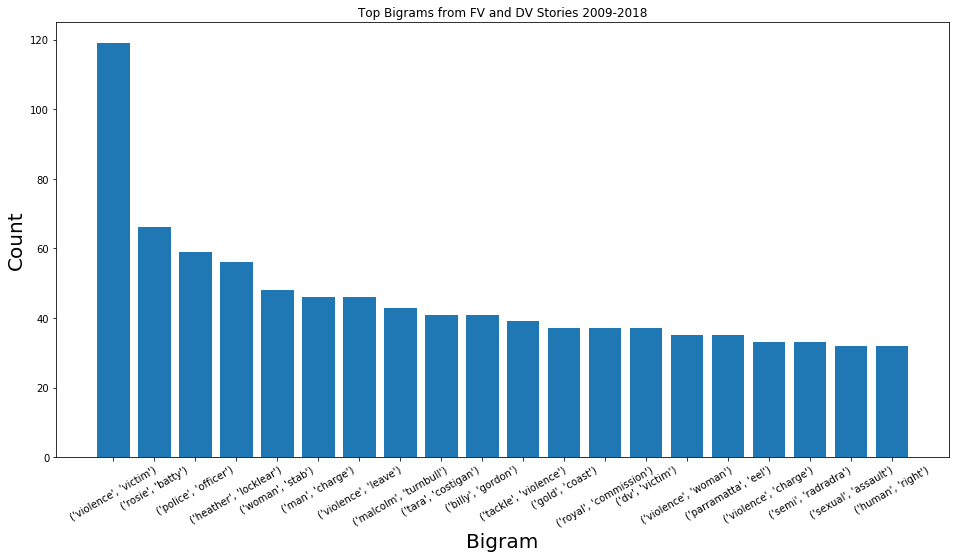

In [12]:
# Top bigrams

x = []          # X axis - bigrams
y = []          # Y axis - counts
count = 0       # Numer of top entities to show

for pair in sorted(bigram_counts, key=bigram_counts.get, reverse=True):
    
    # Remove bias values
    if pair not in [('per', 'cent'), ('fairfax','medium')]:                          
        x.append(pair)
        y.append(bigram_counts[pair])
        count += 1
        if count == 20:                                                        # Limit the num of bigrams to show
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Bigram', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Bigrams from FV and DV Stories 2009-2018')
plt.show()

# Top Entities (Person, Orgnisation, Location)

In [13]:
# Named entity recognition - Spacy library
# Need to run "python -m spacy download en" & "python -m spacy download en_core_web_sm"

import spacy

nlp = spacy.load('en_core_web_sm')          # English language

In [ ]:
person_freqs = {}                    # Named persons - how many percent of stories mentioned them
org_freqs = {}                       # Organisations
loc_freqs = {}                       # Locations

for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Count processed stories and track
    
    for story in col.find({}, no_cursor_timeout=True):
        if story['title'] != None:
            text = story['title']
            
            counted_ents = set()                                      # Count entities only once for each story
            for ent in nlp(text).ents:                                # Spacy named entities
                name = ent.text
                
                if name not in counted_ents:
                    counted_ents.add(name)
                    
                    if ent.label_ == 'PERSON':
                        person_freqs[name] = person_freqs.get(name, 0) + 1
                    if ent.label_ == 'ORG':
                        org_freqs[name] = org_freqs.get(name, 0) + 1
                    if ent.label_ == 'GPE':                                          # Countries/states/...
                        loc_freqs[name] = loc_freqs.get(name, 0) + 1
                    
        counter += 1
        if counter % 100 == 0:
            print(counter, 'processed')

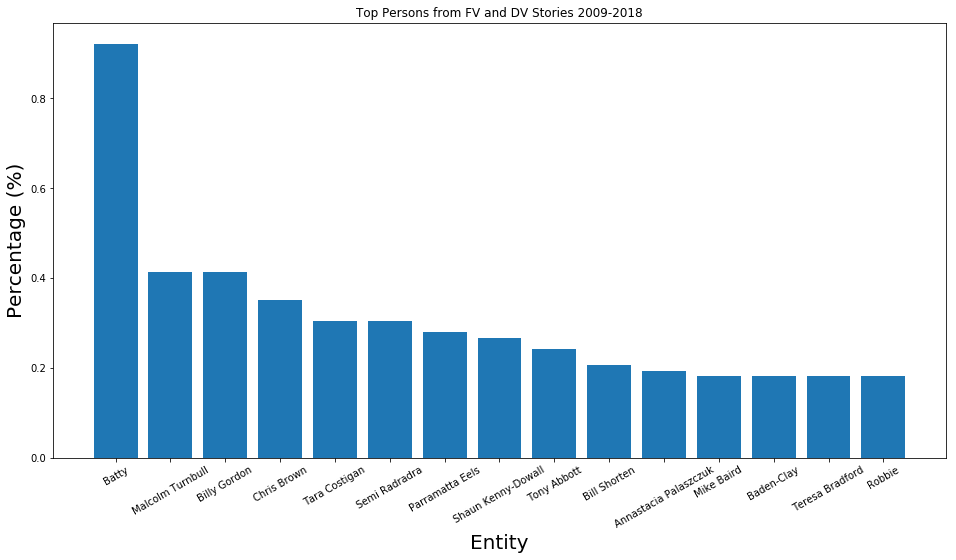

In [16]:
# We combine all the stories under Luke Batty, Rosie Batty and Batty into Batty bucket

# Top persons

freqs = person_freqs

# Adjust for same entities
freqs['Malcolm Turnbull'] += freqs['Turnbull']
freqs['Turnbull'] = 0
freqs['Tony Abbott'] += freqs['Abbott']
freqs['Abbott'] = 0
freqs['Daniel Andrews'] += freqs['Andrews']
freqs['Andrews'] = 0
freqs['Annastacia Palaszczuk'] += freqs['Palaszczuk']
freqs['Palaszczuk'] = 0
freqs['Batty'] += freqs['Rosie Batty'] + freqs['Luke']
freqs['Luke'] = 0
freqs['Rosie Batty'] = 0
freqs['Donald Trump'] += freqs['Trump']
freqs['Trump'] = 0
 
x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['', 'Victoria', 'Victoria Police', 'Mum','Bill','Darwin','Aussie','Killer','Qld']:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:                                                        # Limit the num of entities to show
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Persons from FV and DV Stories 2009-2018')
plt.show()

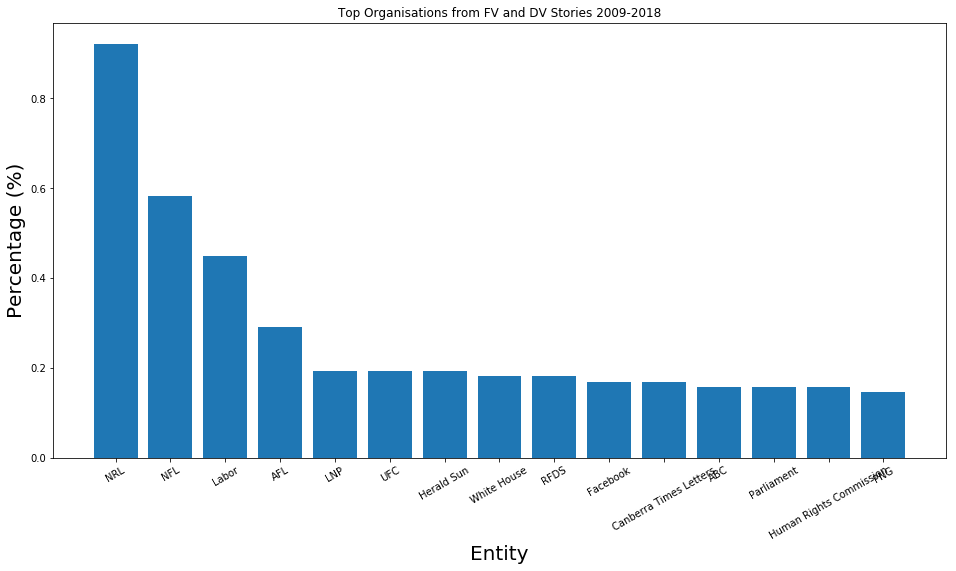

In [22]:
# Top orgs

freqs = org_freqs

# Adjust for same entities
# freqs['Labor'] += freqs['ALP'] + freqs['the Labor Party']
# freqs['ALP'] = 0
# freqs['the Labor Party'] = 0

# freqs['Liberal'] += freqs['the Liberal Party']
# freqs['the Liberal Party'] = 0

x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['',
                           'NSW',
                           'ACT',
                           'Fairfax Media',
                           'Brisbane',
                           'Family Violence',
                           'Western Australia',
                           'CCTV',
                           'The Canberra Times',
                           'Media',
                           'CBD',
                           'WA',
                           'State',
                           'Heather Locklear',
                           'Lodge',
                           'SA',
                           'Gold Coast',
                           'Townsville'
                          ]:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Organisations from FV and DV Stories 2009-2018')
plt.show()

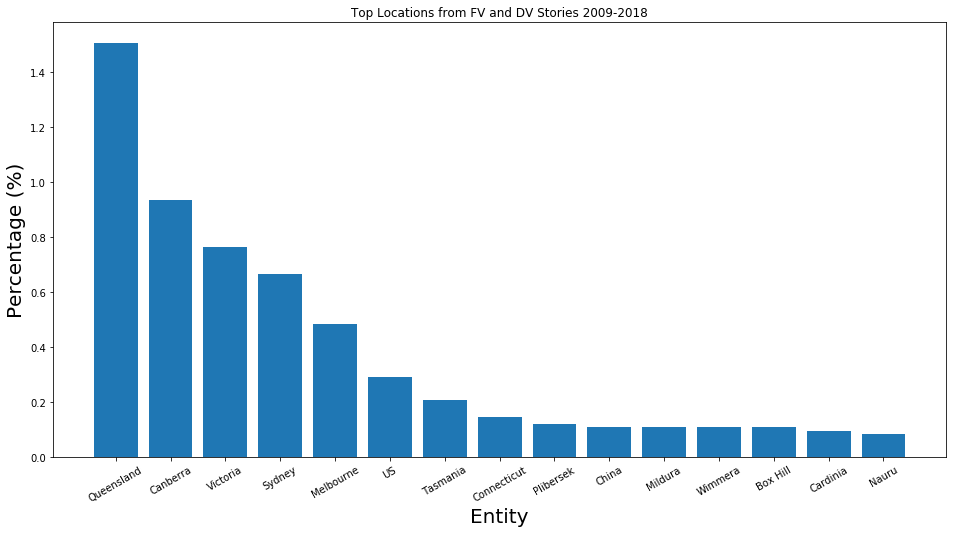

In [27]:
# Top locations

freqs = loc_freqs

freqs['US'] += freqs['the United States']
freqs['the United States'] = 0
freqs['Queensland'] += freqs['Qld']
freqs['Qld'] = 0
freqs['Victoria'] += freqs['Vic']
freqs['Vic'] = 0


x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['',
                           'Fairfax',
                           'Twitter',
                           'Australia',
                           'Mobile',
                           'COAG',
                           'Celeb',
                           'Peris',
                           'LGBTI'
                          ]:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Locations from FV and DV Stories 2009-2018')
plt.show()